# UNET SEGMENTATION

Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [1]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

C:\Users\ALMILA\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ALMILA\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ALMILA\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ALMILA\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

## Data Generator

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [3]:
image_size = 128
train_path = "../unet/dataset/stage1_train/"
test_path =  "../unet/dataset/stage1_test/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]
## Validation Data Size
val_data_size = 10

valid_ids = train_ids
valid_ids = test_ids

In [4]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


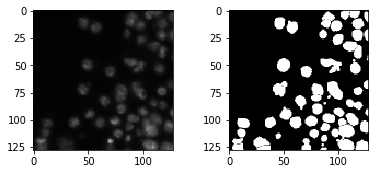

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [12]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [13]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

## Training the model

In [14]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, test_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5
82/83 [============================>.] - ETA: 1s - loss: 0.4182 - acc: 0.8470

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../unet/dataset/stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5\\masks/'

## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")